In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json
import pickle

import scipy as sp
from scipy import signal

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics

#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.layers as L

from keras import Model
from keras.layers import Layer
from tensorflow.python.keras import backend as K
#from keras.backend import backend as K
#import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

from tensorflow.python.keras import optimizers as optimizers


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Num GPUs Available:  1


In [6]:
def encode_phase(df, name):
    phase = df[name].values.tolist()
    x = np.zeros((len(df[name]),1))
    y = np.zeros((len(df[name]),1))
    for i in range (len(phase)): 
        phi = math.radians(phase[i])
        x[i] = math.cos(phi)
        y[i] = math.sin(phi)

    name_x = name[0] + '_ph_hip_x'
    name_y = name[0] + '_ph_hip_y'

    df[name_x] = x
    df[name_y] = y

In [7]:
def encode_gait_percentage(df, name):
    percent = df[name].values.tolist()
    X = np.zeros((len(df[name]),1))
    Y = np.zeros((len(df[name]),1))
    for i in range (len(percent)):
        phi = percent[i] * 2 * math.pi / 100
        X[i] = math.cos(phi)
        Y[i] = math.sin(phi)
    df['X'] = X
    df['Y'] = Y
  
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

def get_train_data_from_df(all_data, test_ratio):
    all_data.info()
    cycle = 0
    cycle_list = []

    start = 0

    for i in range(len(all_data) - 1):
        if (all_data['perc'][i+1] == 0):
            cycle += 1
            cycle_list.append(all_data.iloc[start:i])
            start = i+1

    random.shuffle(cycle_list)
    source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

    # For hip: source_table = source_table.drop(["lgrf", "rgrf", "lcop","rcop"], axis = 1)
    source_table = source_table.drop(["lgrf", "rgrf","lcop","l_ph_hip", "r_ph_hip", "st_sw_phase_l", "st_l_l"], axis = 1)
    source_table
    x = source_table
    x = x.drop(['perc'], axis=1)
    # scaler = MinMaxScaler()
    # x_scaled = scaler.fit_transform(x)
    # x_scaled = pd.DataFrame(x_scaled)

    encode_gait_percentage(source_table, 'perc')
    y = source_table[["X","Y"]]
    # data_x = x_scaled
    data_x=x.values
    x.info()
    data_y = y.values.reshape(-1,2)

    X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                            test_size=0.25,
                            shuffle=False)
    look_back = 10
    fore_cast = 1

    train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
    validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)

    return train_x, train_y, validation_x, validation_y


import random
def get_data_frames_from_files(path, file_names, subject_dict, subjects):
    file_list=[]
    for i in range (len(file_names)):

        subject = file_names[i].split('_')[0]
        if not subject in subjects:
            continue
        else:
            print(file_names[i])
        leg_len = subject_dict[subject][0]
        weight = subject_dict[subject][1]
        tmp=pd.read_excel(path+ file_names[i], sheet_name='Sheet1')
        perc_column = tmp['perc']
        tmp = tmp.drop(columns=['perc'])
        scaler = MinMaxScaler()

    # Normalize each column separately
        normalized_data = scaler.fit_transform(tmp)
        column_names = tmp.columns

        normalized_df = pd.DataFrame(normalized_data, columns=column_names)
        tmp['l_ph_hip']=tmp['l_ph_hip']/300
        tmp['r_ph_hip']=tmp['r_ph_hip']/300
        tmp['l_ph_fo']=tmp['l_ph_fo']/300
        tmp['r_ph_fo']=tmp['r_ph_fo']/300
        tmp['lcop']= tmp['lcop']*1000
        tmp['rcop']=tmp['rcop']*1000
        tmp['strike_frame']=tmp['strike_frame']/400
        tmp['st_sw_phase']=tmp['st_sw_phase']/200
        normalized_df =tmp
        normalized_df['leg_len']=leg_len
        normalized_df['weight']=weight
        normalized_df['perc']= perc_column
        # normalized_df.insert(tmp.columns.get_loc('col1'), 'perc', perc_column)

        file_list.append(normalized_df)

    random.shuffle(file_list)

    all_data = pd.concat(file_list, axis=0, ignore_index=True)
    return all_data



class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        print(x.shape)
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        # context = K.sum(context, axis=1)
        return context

class multiAttentionHead(Layer):
    def __init__(self, num_heads=10, k_dim=64, use_bias=False, **kwargs):
        self.k_dim = self.q_dim = self.v_dim = k_dim
        self.num_heads = num_heads
        self.use_bias = use_bias
        super(multiAttentionHead,self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.f_dim = input_shape[-1]
        #[B,token,feature_dim]*[feature_dim,num_heads,v_dim/q_dim/k_dim]->[B,token,num_heads,q_dim/k_dim/v_dim]
        if self.use_bias:
            self.query_dense = einsum_dense.EinsumDense('abc,cde->abde', output_shape=[None, self.num_heads, self.q_dim], bias_axes='de')
            self.key_dense = einsum_dense.EinsumDense('abc,cde->abde', output_shape=[None, self.num_heads, self.k_dim], bias_axes='de')
            self.value_dense = einsum_dense.EinsumDense('abc,cde->abde', output_shape=[None, self.num_heads, self.v_dim], bias_axes='de')
            #[B,token,num_heads,v_dim]*[num_heads,v_dim,feature_dim]->[B,token,feature_dim]
            self.Wo = einsum_dense.EinsumDense('abcd,cde->abe', output_shape=[None, self.f_dim], bias_axes='e')
        else:
            self.query_dense = einsum_dense.EinsumDense('abc,cde->abde', output_shape=[None, self.num_heads, self.q_dim])
            self.key_dense = einsum_dense.EinsumDense('abc,cde->abde', output_shape=[None, self.num_heads, self.k_dim])
            self.value_dense = einsum_dense.EinsumDense('abc,cde->abde', output_shape=[None, self.num_heads, self.v_dim])
            #[B,token,num_heads,v_dim]*[num_heads,v_dim,feature_dim]->[B,token,feature_dim]
            self.Wo = einsum_dense.EinsumDense('abcd,cde->abe', output_shape=[None, self.f_dim])
        super(multiAttentionHead, self).build(input_shape)
    
    def call(self, input_vec, attention_mask=None):
        query = self.query_dense(input_vec)#[B,token,num_heads,q_dim]
        key = self.key_dense(input_vec)#[B,token,num_heads,k_dim]
        value = self.value_dense(input_vec)#[B,token,num_heads,v_dim]
        #[B,token,num_heads,q_dim]*[B,token,num_heads,k_dim]->[B,num_heads,token,token]
        scaleddotproduct =  special_math_ops.einsum('abcd,aecd->acbe', query, key)
        scaleddotproduct = tf.math.divide(scaleddotproduct, float(math.sqrt(self.k_dim)))
        if attention_mask:
            scaleddotproduct = tf.where(attention_mask, scaleddotproduct, -1e9)
        softmax = tf.nn.softmax(scaleddotproduct, axis=-1)
        #[B,num_heads,token,token]*[B,token,num_heads,v_dim]->[B,token,num_heads,v_dim]
        softmax_value = special_math_ops.einsum('acbe,aecd->abcd', softmax, value)
        #[B,token,num_heads,v_dim]*[num_heads,v_dim,feature_dim]->[B,token,feature_dim]
        final = self.Wo(softmax_value)
        return final    

class ElementwiseMultiply(Layer):
    def __init__(self, units, **kwargs):
        super(ElementwiseMultiply, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel", shape=(self.units,), initializer="glorot_uniform", trainable=True)
        super(ElementwiseMultiply, self).build(input_shape)

    def call(self, inputs):
        return inputs * self.kernel

    
class Sampling(L.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var, p = inputs
        p1=tf.reduce_sum(p[0])
        # p1=.
        p2=tf.reduce_sum(p[1])
        # print(p1)
        # print(p2)
        # weights_length_values = p.numpy()
        # print(weights_length_values)
        batch = tf.shape(z_mean)[0]
        seq = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        epsilon = tf.random.normal(shape=(batch, seq, dim))
        return p1*z_mean + tf.exp(0.5 * z_log_var) * epsilon*p2
   
def motion_encoder_model():
    seq_len =10
    n_features=train_x.shape[2]
    inp=Input(shape=(seq_len, n_features))

def encoder_model():
    seq_len=10
    n_features=train_x.shape[2]
    x=Input(shape=(seq_len, n_features))
    part_1 = x[:, :, :n_features-2]

    part_2 = x[0, 0, n_features-2:]

    part_3 = x[:, :, n_features-7:n_features-2]
    # l2=tf.keras.layers.AveragePooling1D(
    #     pool_size=2,
    #     strides=1, padding="same")(part_3)
    # lin_l2=L.Dense(8)(part_3)
    lin_l2 = attention()(part_3)
    lin_l3=L.Dense(4)(lin_l2)

    LSTM_layer2 = LSTM(8, return_sequences=True)(lin_l2)

    print(part_2)
    l1=tf.keras.layers.Conv1D(16, 2, padding="same")(part_1)
    # weighted_param=L.Dense(2)(part_2)
    weighted_param = ElementwiseMultiply(units=2)(part_2)

    # l1=tf.keras.layers.AveragePooling1D(
    #     pool_size=2,
    #     strides=1, padding="same")(part_1)
    # lin_l1=L.Dense(4)(l1)
    # att_multi =multiAttentionHead(num_heads=4,k_dim=2,use_bias=True)
    
    # att_op = att_multi(l1)
    att_op=attention()(l1)
    # att1 = attention()(part_1)
    # layer_normed = L.LayerNormalization(axis=-1)(att_op)

    # tmp_inp=L.Concatenate()([att1, part_2])

    # rep_layer = L.RepeatVector((seq_len))(att1);
    # tmp_inp=L.Concatenate()([att1, part_2])

    # latent_sp=L.TimeDistributed(Dense(4))(rep_layer)
    # f1=tf.keras.layers.Flatten()(l1)
    # print(l1.shape)
    # lstm_inp=L.Concatenate(axis=2)([lin_l1, rep_layer, part_2])
    # RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    LSTM_layer1 = LSTM(32, return_sequences=True)(att_op)
    # LSTM_layer2 = LSTM(8, return_sequences=True)(LSTM_layer1)

    concat_layer=L.Concatenate(axis=2)([LSTM_layer1, lin_l3])
    # layer_normed = L.LayerNormalization(axis=-1)(LSTM_layer2)

    # attn_layer1 = attention()(LSTM_layer2)
    mean = L.Dense(2)(concat_layer)
    log_var= L.Dense(2)(concat_layer)
    z = Sampling()([mean, log_var, weighted_param])
    latent_sp=L.TimeDistributed(L.Dense(4))(concat_layer)

    encoder = tf.keras.Model(x, (mean, log_var, z, latent_sp), name="Encoder")
    return encoder  
    # seq_len=10
    # n_features=train_x.shape[2]
    # x=Input(shape=(seq_len, n_features))
    # part_1 = x[:, :, :n_features-2]

    # part_2 = x[0, 0, n_features-2:]

    # part_3 = x[:, :, n_features-5:n_features-2]
    # # l2=tf.keras.layers.AveragePooling1D(
    # #     pool_size=2,
    # #     strides=1, padding="same")(part_3)
    # lin_l2=L.Dense(8)(part_3)
    # lin_l3=L.Dense(4)(lin_l2)

    # # LSTM_layer2 = LSTM(16, return_sequences=True)(lin_l2)

    # print(part_2)
    # l1=tf.keras.layers.AveragePooling1D(
    #     pool_size=2,
    #     strides=1, padding="same")(part_1)
    # lin_l1=L.Dense(4)(l1)

    # att1 = attention()(part_1)
    # # tmp_inp=L.Concatenate()([att1, part_2])

    # rep_layer = L.RepeatVector((seq_len))(att1);
    # # tmp_inp=L.Concatenate()([att1, part_2])

    # # latent_sp=L.TimeDistributed(Dense(4))(rep_layer)
    # # f1=tf.keras.layers.Flatten()(l1)
    # # print(l1.shape)
    # # lstm_inp=L.Concatenate(axis=2)([lin_l1, rep_layer, part_2])
    # # RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    # LSTM_layer1 = LSTM(32, return_sequences=True)(rep_layer)
    # # LSTM_layer2 = LSTM(8, return_sequences=True)(LSTM_layer1)

    # concat_layer=L.Concatenate(axis=2)([LSTM_layer1, lin_l3])

    # # attn_layer1 = attention()(LSTM_layer2)
    # mean = L.Dense(3)(concat_layer)
    # log_var= L.Dense(3)(concat_layer)
    # z = Sampling()([mean, log_var, part_2])
    # latent_sp=L.TimeDistributed(L.Dense(4))(concat_layer)

    # encoder = tf.keras.Model(x, (mean, log_var, z, latent_sp), name="Encoder")
    # return encoder      

def decoder_model():
        
    latent_dim =(10,8)
    n_features=train_x.shape[2]

    n_real_features = n_features -2
    input_1_shape=(10,2)
    input_2_shape=( 10,4)
    # input_3_shape=( 10,3)
    input1 = tf.keras.Input(shape=input_1_shape, name='input_layer1')
    input2 = tf.keras.Input(shape=input_2_shape, name='input_layer2')
    concat1= L.Concatenate(axis=2)
    concatenated_input = L.Concatenate(axis=2)([input1, input2])
    # pooled_l = L.AveragePooling2D(pool_size=)
    # f=Flatten()(concatenated_input)
    # print(f)
    dec_l1 = L.Dense(8)(concatenated_input)
    # rep_layer = L.RepeatVector((seq_len))(dec_l1);
    dec_LSTM_layer1 = LSTM(32, return_sequences=True)(dec_l1)
    dec_LSTM_layer2 = LSTM(8, return_sequences=True)(dec_LSTM_layer1)

    lin_layer = L.TimeDistributed(L.Dense(n_real_features))(dec_LSTM_layer2)

    # tmp_layer = Flatten()(dec_LSTM_layer)
    # lin_layer = L.Dense(2)(tmp_layer)
    decoder = tf.keras.Model([input1, input2], lin_layer, name="Decoder")
    return decoder


seq_len=10
n_features=11
train_x=np.zeros((10,10,11))
#encoder_model().summary()
#decoder_model().summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, ls = self.encoder(data)
            # inp_dec = tf.concat((z, ls, p2), axis=2)
            # print(inp_dec)
            reconstruction = self.decoder([z,ls])
            # tmp1=keras.losses.binary_crossentropy(data, reconstruction)
            # reconstruction_loss = K.mean(K.square(data - reconstruction))
            mse = tf.keras.losses.MeanSquaredError()
            n_features = data.shape[2] 
            real_data = data[:,:,0:n_features-2]
            reconstruction_loss = mse(real_data, reconstruction)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction)
            #     )
            # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1,2)))
            total_loss = 1.5*reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
def train_vae(train_x):
    enc=encoder_model()
    dec=decoder_model()
    vae = VAE(enc, dec)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(train_x, epochs=22, batch_size=128, verbose=2)

    return vae.encoder,vae.decoder


def test_model_get_results(encoder, mlp_model, validation_x, validation_y, display_flag, tag, file):
    print("validation_x shape",validation_x.shape)
    _,_,samp_v, ls_v=encoder.predict(validation_x)
    ls_v = tf.concat((samp_v, ls_v), axis=2)
    print('Encoded time-series shape', ls_v.shape)
    testPredict = mlp_model.predict(ls_v)
    print(validation_y.shape)
    print(testPredict.shape)
    testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
    # print(testScore)
    # print('Test Score: %.2f RMSE' % (testScore))
    pred = np.zeros((len(testPredict),1))

    for iter in range(len(testPredict)):
        x = testPredict[iter][0]
        y = testPredict[iter][1]
        pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

    actual = np.zeros((len(validation_y),1))

    for iter in range(len(validation_y)):
        x =validation_y[iter][0]
        y =validation_y[iter][1]
        # st_frame = validation_x[0,9,7]

        actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))
        # if st_frame>100 and pred[iter]<15:
        #     pred[iter]=100-pred[iter]
        # if st_frame<90 and pred[iter]>85:
        #     pred[iter]=100-pred[iter]


    cor_actual=[]
    cor_pred=[]
    prec_list=[]

    for i in range(5):
        correct = 0
        for iter in range(len(actual)):
            # if (actual[iter]>98) or(actual[iter]<3):
            #     correct+=1
            #     continue
            if (abs(actual[iter] - pred[iter]) <= (i+1)):
                correct+=1
            cor_pred.append(pred[iter])
            cor_actual.append(actual[iter])
        prec=correct * 100/len(actual)
        print("Precision ", i+1, ": ", prec)
        # file.write(str(prec))
        # file.write("\n")
        prec_list.append(prec)

    rmse = 0
    length = len(actual)
    for i in range(len(actual)):
        if abs (pred[i] - actual[i]) >=90:
            length -= 1
        else:
            rmse = rmse + pow(pred[i] - actual[i], 2)
    rmse = rmse / length
    rmse = math.sqrt(rmse)

    if os.path.exists(result_pkl_file):
        with open(result_pkl_file,'rb') as pkl_file:
            res_dict=pickle.load(pkl_file)
    else:
        res_dict={}
    result={}
    result['rmse']=rmse
    result['prec_list']=prec_list
    res_dict[tag]=result
    with open(result_pkl_file, 'wb')as pkl_file:
        pickle.dump(res_dict, pkl_file)


    print(rmse)
    # file.write("rmse "+str(rmse))
    # file.write("\n")
    if display_flag:
        plt.scatter(cor_actual, cor_pred, facecolors='none', edgecolors='crimson',alpha=0.4)
        p1 = max(max(cor_pred), max(cor_actual))
        p2 = min(min(cor_pred), min(cor_actual))

        ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

        plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
        plt.title('Actual vs Prediction')
        plt.savefig(result_path+tag+"__res.png")

    return prec_list, rmse


def train_mlp_model(samp_t, train_y):
    mlp_model = Sequential()

    mlp_model.add(tf.keras.Input(shape=(samp_t.shape[1], samp_t.shape[2]), name='input_layer'))
    mlp_model.add(LSTM(32))

    mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu'))
    # mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(samp_t.shape[1]*samp_t.shape[2])))
    # mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

    mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
    mlp_model.add(L.Dense(2))
    mlp_model.summary()

    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    adam = tf.keras.optimizers.Adam(lr_schedule)

    mlp_model.compile(loss='mse', optimizer=adam)

    epochs = 25
    batch=64                                                                                                                                                           
    # lrate = LearningRateScheduler(step_decay)
    monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3)
    # train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

    # train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
    # train_encoded_reshaped = train_encoded
    callback_list = [monitor]
    mlp_history = mlp_model.fit(samp_t , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

    return mlp_model

def create_latent_space_train_mlp(encoder, train_x):
  print("OKAY till here 2")
  _,_,samp_t, ls_t=encoder.predict(train_x)
  print("OKAY till here 3")

  ls_t = tf.concat((samp_t, ls_t), axis=2)
  print('Encoded time-series shape', ls_t.shape)
  return ls_t


Subject combination : ['AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572285 entries, 0 to 572284
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           572285 non-null  float64
 1   rcop           572285 non-null  float64
 2   lgrf           572285 non-null  float64
 3   rgrf           572285 non-null  float64
 4   l_ph_hip       572285 non-null  float64
 5   r_ph_hip       572285 non-null  float64
 6   st_sw_phase_l  572285 non-null  float64
 7   st_sw_phase_r  572285 non-null  float64
 8   r_ph_hip_x     572285 non-null  float64
 9   r_ph_hip_y     572285 non-null  float64
 10  st_l_l         572285 non-null  float64
 11  st_l_r         572285 non-null  float64
 12  leg_len        572285 non-null  float64
 13  weight         572285 non-null  float64
 14  perc           572285 non-null  float64
dtypes: float64(1

2024-01-19 17:34:01.924971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 17:34:01.925681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 17:34:01.926153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 17:34:05.066800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 17:34:05.066834: I tensorflow/core/common_runtime/gpu/gpu

(None, 10, 5)
<KerasTensor shape=(2,), dtype=float32, sparse=False, name=keras_tensor_2>
(None, 10, 16)
Epoch 1/22
(None, 10, 5)
(None, 10, 16)
(None, 10, 5)
(None, 10, 16)


2024-01-19 17:34:13.174458: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


3337/3337 - 201s - 60ms/step - kl_loss: 6.0234e-04 - reconstruction_loss: 0.0163 - total_loss: 0.0251
Epoch 2/22
3337/3337 - 188s - 56ms/step - kl_loss: 5.2517e-06 - reconstruction_loss: 1.4288e-04 - total_loss: 2.1957e-04
Epoch 3/22
3337/3337 - 189s - 57ms/step - kl_loss: 2.0219e-06 - reconstruction_loss: 3.1643e-05 - total_loss: 4.9487e-05
Epoch 4/22
3337/3337 - 189s - 57ms/step - kl_loss: 1.2152e-06 - reconstruction_loss: 1.7780e-05 - total_loss: 2.7885e-05
Epoch 5/22
3337/3337 - 188s - 56ms/step - kl_loss: 9.2405e-07 - reconstruction_loss: 1.3205e-05 - total_loss: 2.0731e-05
Epoch 6/22
3337/3337 - 188s - 56ms/step - kl_loss: 6.9192e-07 - reconstruction_loss: 9.9286e-06 - total_loss: 1.5585e-05
Epoch 7/22
3337/3337 - 189s - 57ms/step - kl_loss: 6.7078e-07 - reconstruction_loss: 8.9324e-06 - total_loss: 1.4069e-05
Epoch 8/22
3337/3337 - 192s - 57ms/step - kl_loss: 5.2454e-07 - reconstruction_loss: 7.4452e-06 - total_loss: 1.1692e-05
Epoch 9/22
3337/3337 - 186s - 56ms/step - kl_loss: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6674/6674 - 111s - 17ms/step - loss: 0.0355
Epoch 2/25
6674/6674 - 110s - 16ms/step - loss: 0.0237
Epoch 3/25
6674/6674 - 111s - 17ms/step - loss: 0.0200
Epoch 4/25
6674/6674 - 112s - 17ms/step - loss: 0.0174
Epoch 5/25
6674/6674 - 110s - 17ms/step - loss: 0.0153
Epoch 6/25
6674/6674 - 110s - 17ms/step - loss: 0.0140
Epoch 7/25
6674/6674 - 111s - 17ms/step - loss: 0.0131
Epoch 8/25
6674/6674 - 111s - 17ms/step - loss: 0.0125
Epoch 9/25
6674/6674 - 111s - 17ms/step - loss: 0.0121
Epoch 10/25
6674/6674 - 111s - 17ms/step - loss: 0.0118
Epoch 11/25
6674/6674 - 111s - 17ms/step - loss: 0.0115
Epoch 12/25
6674/6674 - 110s - 17ms/step - loss: 0.0112
Epoch 13/25
6674/6674 - 111s - 17ms/step - loss: 0.0111
Epoch 14/25
6674/6674 - 111s - 17ms/step - loss: 0.0109
Epoch 15/25
6674/6674 - 111s - 17ms/step - loss: 0.0108
Epoch 16/25
6674/6674 - 111s - 17ms/step - loss: 0.0106
Epoch 17/25
6674/6674 - 112s - 17ms/step - loss: 0.0104
Epoch 18/25
6674/6674 - 113s - 17ms/step - loss: 0.0103
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.7054298830072834
testing on : VP
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54773 entries, 0 to 54772
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           54773 non-null  float64
 1   rcop           54773 non-null  float64
 2   lgrf           54773 non-null  float64
 3   rgrf           54773 non-null  float64
 4   l_ph_hip       54773 non-null  float64
 5   r_ph_hip       54773 non-null  float64
 6   st_sw_phase_l  54773 non-null  float64
 7   st_sw_phase_r  54773 non-null  float64
 8   r_ph_hip_x     54773 non-null  float64
 9   r_ph_hip_y     54773 non-null  float64
 10  st_l_l         54773 non-null  float64
 11  st_l_r         54773 non-null  float64
 12  leg_len        54773 non-null  float64
 13  weight         54773 non-null  float64
 14  perc           54773 non-null  float64
dtypes: float64(15)
memory usage: 6.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54286 entries, 0 

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569770 entries, 0 to 569769
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           569770 non-null  float64
 1   rcop           569770 non-null  float64
 2   lgrf           569770 non-null  float64
 3   rgrf           569770 non-null  float64
 4   l_ph_hip       569770 non-null  float64
 5   r_ph_hip       569770 non-null  float64
 6   st_sw_phase_l  569770 non-null  float64
 7   st_sw_phase_r  569770 non-null  float64
 8   r_ph_hip_x     569770 non-null  float64
 9   r_ph_hip_y     569770 non-null  float64
 10  st_l_l         569770 non-null  float64
 11  st_l_r         569770 non-null  float64
 12  leg_len        569770 non-null  float64
 13  weight         569770 non-null  float64
 14  perc           569770 non-null  float64
dtypes: float64(1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6646/6646 - 103s - 15ms/step - loss: 0.0335
Epoch 2/25
6646/6646 - 102s - 15ms/step - loss: 0.0207
Epoch 3/25
6646/6646 - 103s - 15ms/step - loss: 0.0170
Epoch 4/25
6646/6646 - 103s - 15ms/step - loss: 0.0148
Epoch 5/25
6646/6646 - 103s - 15ms/step - loss: 0.0134
Epoch 6/25
6646/6646 - 103s - 15ms/step - loss: 0.0126
Epoch 7/25
6646/6646 - 104s - 16ms/step - loss: 0.0118
Epoch 8/25
6646/6646 - 103s - 16ms/step - loss: 0.0115
Epoch 9/25
6646/6646 - 103s - 15ms/step - loss: 0.0111
Epoch 10/25
6646/6646 - 103s - 15ms/step - loss: 0.0108
Epoch 11/25
6646/6646 - 103s - 16ms/step - loss: 0.0105
Epoch 12/25
6646/6646 - 104s - 16ms/step - loss: 0.0104
Epoch 13/25
6646/6646 - 104s - 16ms/step - loss: 0.0102
Epoch 14/25
6646/6646 - 103s - 16ms/step - loss: 0.0100
Epoch 15/25
6646/6646 - 103s - 16ms/step - loss: 0.0099
Epoch 16/25
6646/6646 - 103s - 16ms/step - loss: 0.0097
Epoch 17/25
6646/6646 - 103s - 16ms/step - loss: 0.0095
Epoch 18/25
6646/6646 - 104s - 16ms/step - loss: 0.0095
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.4024392379435926
testing on : AK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57288 entries, 0 to 57287
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           57288 non-null  float64
 1   rcop           57288 non-null  float64
 2   lgrf           57288 non-null  float64
 3   rgrf           57288 non-null  float64
 4   l_ph_hip       57288 non-null  float64
 5   r_ph_hip       57288 non-null  float64
 6   st_sw_phase_l  57288 non-null  float64
 7   st_sw_phase_r  57288 non-null  float64
 8   r_ph_hip_x     57288 non-null  float64
 9   r_ph_hip_y     57288 non-null  float64
 10  st_l_l         57288 non-null  float64
 11  st_l_r         57288 non-null  float64
 12  leg_len        57288 non-null  float64
 13  weight         57288 non-null  float64
 14  perc           57288 non-null  float64
dtypes: float64(15)
memory usage: 6.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56821 entries, 0 

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579277 entries, 0 to 579276
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           579277 non-null  float64
 1   rcop           579277 non-null  float64
 2   lgrf           579277 non-null  float64
 3   rgrf           579277 non-null  float64
 4   l_ph_hip       579277 non-null  float64
 5   r_ph_hip       579277 non-null  float64
 6   st_sw_phase_l  579277 non-null  float64
 7   st_sw_phase_r  579277 non-null  float64
 8   r_ph_hip_x     579277 non-null  float64
 9   r_ph_hip_y     579277 non-null  float64
 10  st_l_l         579277 non-null  float64
 11  st_l_r         579277 non-null  float64
 12  leg_len        579277 non-null  float64
 13  weight         579277 non-null  float64
 14  perc           579277 non-null  float64
dtypes: float64(1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_24 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_25 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_26 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6755/6755 - 103s - 15ms/step - loss: 0.0353
Epoch 2/25
6755/6755 - 101s - 15ms/step - loss: 0.0218
Epoch 3/25
6755/6755 - 101s - 15ms/step - loss: 0.0181
Epoch 4/25
6755/6755 - 101s - 15ms/step - loss: 0.0156
Epoch 5/25
6755/6755 - 102s - 15ms/step - loss: 0.0141
Epoch 6/25
6755/6755 - 102s - 15ms/step - loss: 0.0128
Epoch 7/25
6755/6755 - 102s - 15ms/step - loss: 0.0121
Epoch 8/25
6755/6755 - 102s - 15ms/step - loss: 0.0115
Epoch 9/25
6755/6755 - 102s - 15ms/step - loss: 0.0112
Epoch 10/25
6755/6755 - 102s - 15ms/step - loss: 0.0108
Epoch 11/25
6755/6755 - 102s - 15ms/step - loss: 0.0105
Epoch 12/25
6755/6755 - 102s - 15ms/step - loss: 0.0104
Epoch 13/25
6755/6755 - 102s - 15ms/step - loss: 0.0102
Epoch 14/25
6755/6755 - 102s - 15ms/step - loss: 0.0101
Epoch 15/25
6755/6755 - 101s - 15ms/step - loss: 0.0099
Epoch 16/25
6755/6755 - 102s - 15ms/step - loss: 0.0098
Epoch 17/25
6755/6755 - 104s - 15ms/step - loss: 0.0096
Epoch 18/25
6755/6755 - 102s - 15ms/step - loss: 0.0096
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.8964916192458916
testing on : SD
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47781 entries, 0 to 47780
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           47781 non-null  float64
 1   rcop           47781 non-null  float64
 2   lgrf           47781 non-null  float64
 3   rgrf           47781 non-null  float64
 4   l_ph_hip       47781 non-null  float64
 5   r_ph_hip       47781 non-null  float64
 6   st_sw_phase_l  47781 non-null  float64
 7   st_sw_phase_r  47781 non-null  float64
 8   r_ph_hip_x     47781 non-null  float64
 9   r_ph_hip_y     47781 non-null  float64
 10  st_l_l         47781 non-null  float64
 11  st_l_r         47781 non-null  float64
 12  leg_len        47781 non-null  float64
 13  weight         47781 non-null  float64
 14  perc           47781 non-null  float64
dtypes: float64(15)
memory usage: 5.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47365 entries, 0 

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567615 entries, 0 to 567614
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           567615 non-null  float64
 1   rcop           567615 non-null  float64
 2   lgrf           567615 non-null  float64
 3   rgrf           567615 non-null  float64
 4   l_ph_hip       567615 non-null  float64
 5   r_ph_hip       567615 non-null  float64
 6   st_sw_phase_l  567615 non-null  float64
 7   st_sw_phase_r  567615 non-null  float64
 8   r_ph_hip_x     567615 non-null  float64
 9   r_ph_hip_y     567615 non-null  float64
 10  st_l_l         567615 non-null  float64
 11  st_l_r         567615 non-null  float64
 12  leg_len        567615 non-null  float64
 13  weight         567615 non-null  float64
 14  perc           567615 non-null  float64
dtypes: float64(1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_33 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_34 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_35 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6621/6621 - 104s - 16ms/step - loss: 0.0372
Epoch 2/25
6621/6621 - 102s - 15ms/step - loss: 0.0228
Epoch 3/25
6621/6621 - 102s - 15ms/step - loss: 0.0195
Epoch 4/25
6621/6621 - 103s - 16ms/step - loss: 0.0171
Epoch 5/25
6621/6621 - 102s - 15ms/step - loss: 0.0157
Epoch 6/25
6621/6621 - 102s - 15ms/step - loss: 0.0146
Epoch 7/25
6621/6621 - 103s - 16ms/step - loss: 0.0140
Epoch 8/25
6621/6621 - 103s - 15ms/step - loss: 0.0134
Epoch 9/25
6621/6621 - 102s - 15ms/step - loss: 0.0131
Epoch 10/25
6621/6621 - 102s - 15ms/step - loss: 0.0128
Epoch 11/25
6621/6621 - 101s - 15ms/step - loss: 0.0125
Epoch 12/25
6621/6621 - 101s - 15ms/step - loss: 0.0122
Epoch 13/25
6621/6621 - 103s - 16ms/step - loss: 0.0120
Epoch 14/25
6621/6621 - 102s - 15ms/step - loss: 0.0118
Epoch 15/25
6621/6621 - 103s - 16ms/step - loss: 0.0117
Epoch 16/25
6621/6621 - 103s - 16ms/step - loss: 0.0115
Epoch 17/25
6621/6621 - 103s - 15ms/step - loss: 0.0112
Epoch 18/25
6621/6621 - 102s - 15ms/step - loss: 0.0111
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.680469504213062
testing on : PH
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59443 entries, 0 to 59442
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           59443 non-null  float64
 1   rcop           59443 non-null  float64
 2   lgrf           59443 non-null  float64
 3   rgrf           59443 non-null  float64
 4   l_ph_hip       59443 non-null  float64
 5   r_ph_hip       59443 non-null  float64
 6   st_sw_phase_l  59443 non-null  float64
 7   st_sw_phase_r  59443 non-null  float64
 8   r_ph_hip_x     59443 non-null  float64
 9   r_ph_hip_y     59443 non-null  float64
 10  st_l_l         59443 non-null  float64
 11  st_l_r         59443 non-null  float64
 12  leg_len        59443 non-null  float64
 13  weight         59443 non-null  float64
 14  perc           59443 non-null  float64
dtypes: float64(15)
memory usage: 6.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58909 entries, 0 t

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577457 entries, 0 to 577456
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           577457 non-null  float64
 1   rcop           577457 non-null  float64
 2   lgrf           577457 non-null  float64
 3   rgrf           577457 non-null  float64
 4   l_ph_hip       577457 non-null  float64
 5   r_ph_hip       577457 non-null  float64
 6   st_sw_phase_l  577457 non-null  float64
 7   st_sw_phase_r  577457 non-null  float64
 8   r_ph_hip_x     577457 non-null  float64
 9   r_ph_hip_y     577457 non-null  float64
 10  st_l_l         577457 non-null  float64
 11  st_l_r         577457 non-null  float64
 12  leg_len        577457 non-null  float64
 13  weight         577457 non-null  float64
 14  perc           577457 non-null  float64
dtypes: float64(1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_42 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_43 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_44 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6735/6735 - 105s - 16ms/step - loss: 0.0253
Epoch 2/25
6735/6735 - 103s - 15ms/step - loss: 0.0166
Epoch 3/25
6735/6735 - 104s - 15ms/step - loss: 0.0139
Epoch 4/25
6735/6735 - 104s - 15ms/step - loss: 0.0125
Epoch 5/25
6735/6735 - 105s - 16ms/step - loss: 0.0116
Epoch 6/25
6735/6735 - 104s - 15ms/step - loss: 0.0109
Epoch 7/25
6735/6735 - 104s - 15ms/step - loss: 0.0105
Epoch 8/25
6735/6735 - 104s - 15ms/step - loss: 0.0102
Epoch 9/25
6735/6735 - 105s - 16ms/step - loss: 0.0100
Epoch 10/25
6735/6735 - 105s - 16ms/step - loss: 0.0099
Epoch 11/25
6735/6735 - 104s - 15ms/step - loss: 0.0096
Epoch 12/25
6735/6735 - 103s - 15ms/step - loss: 0.0094
Epoch 13/25
6735/6735 - 103s - 15ms/step - loss: 0.0093
Epoch 14/25
6735/6735 - 103s - 15ms/step - loss: 0.0092
Epoch 15/25
6735/6735 - 103s - 15ms/step - loss: 0.0090
Epoch 16/25
6735/6735 - 102s - 15ms/step - loss: 0.0089
Epoch 17/25
6735/6735 - 103s - 15ms/step - loss: 0.0088
Epoch 18/25
6735/6735 - 103s - 15ms/step - loss: 0.0087
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


1.9596521058907428
testing on : YC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49601 entries, 0 to 49600
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           49601 non-null  float64
 1   rcop           49601 non-null  float64
 2   lgrf           49601 non-null  float64
 3   rgrf           49601 non-null  float64
 4   l_ph_hip       49601 non-null  float64
 5   r_ph_hip       49601 non-null  float64
 6   st_sw_phase_l  49601 non-null  float64
 7   st_sw_phase_r  49601 non-null  float64
 8   r_ph_hip_x     49601 non-null  float64
 9   r_ph_hip_y     49601 non-null  float64
 10  st_l_l         49601 non-null  float64
 11  st_l_r         49601 non-null  float64
 12  leg_len        49601 non-null  float64
 13  weight         49601 non-null  float64
 14  perc           49601 non-null  float64
dtypes: float64(15)
memory usage: 5.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49180 entries, 0 

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JS', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581777 entries, 0 to 581776
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           581777 non-null  float64
 1   rcop           581777 non-null  float64
 2   lgrf           581777 non-null  float64
 3   rgrf           581777 non-null  float64
 4   l_ph_hip       581777 non-null  float64
 5   r_ph_hip       581777 non-null  float64
 6   st_sw_phase_l  581777 non-null  float64
 7   st_sw_phase_r  581777 non-null  float64
 8   r_ph_hip_x     581777 non-null  float64
 9   r_ph_hip_y     581777 non-null  float64
 10  st_l_l         581777 non-null  float64
 11  st_l_r         581777 non-null  float64
 12  leg_len        581777 non-null  float64
 13  weight         581777 non-null  float64
 14  perc           581777 non-null  float64
dtypes: float64(1

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_51 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_52 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_53 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6785/6785 - 105s - 15ms/step - loss: 0.0345
Epoch 2/25
6785/6785 - 103s - 15ms/step - loss: 0.0197
Epoch 3/25
6785/6785 - 103s - 15ms/step - loss: 0.0166
Epoch 4/25
6785/6785 - 103s - 15ms/step - loss: 0.0148
Epoch 5/25
6785/6785 - 103s - 15ms/step - loss: 0.0135
Epoch 6/25
6785/6785 - 103s - 15ms/step - loss: 0.0128
Epoch 7/25
6785/6785 - 103s - 15ms/step - loss: 0.0122
Epoch 8/25
6785/6785 - 103s - 15ms/step - loss: 0.0119
Epoch 9/25
6785/6785 - 101s - 15ms/step - loss: 0.0115
Epoch 10/25
6785/6785 - 103s - 15ms/step - loss: 0.0113
Epoch 11/25
6785/6785 - 103s - 15ms/step - loss: 0.0110
Epoch 12/25
6785/6785 - 104s - 15ms/step - loss: 0.0108
Epoch 13/25
6785/6785 - 104s - 15ms/step - loss: 0.0106
Epoch 14/25
6785/6785 - 103s - 15ms/step - loss: 0.0105
Epoch 15/25
6785/6785 - 103s - 15ms/step - loss: 0.0103
Epoch 16/25
6785/6785 - 106s - 16ms/step - loss: 0.0102
Epoch 17/25
6785/6785 - 104s - 15ms/step - loss: 0.0100
Epoch 18/25
6785/6785 - 105s - 15ms/step - loss: 0.0100
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.65497902456382
testing on : JL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45281 entries, 0 to 45280
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           45281 non-null  float64
 1   rcop           45281 non-null  float64
 2   lgrf           45281 non-null  float64
 3   rgrf           45281 non-null  float64
 4   l_ph_hip       45281 non-null  float64
 5   r_ph_hip       45281 non-null  float64
 6   st_sw_phase_l  45281 non-null  float64
 7   st_sw_phase_r  45281 non-null  float64
 8   r_ph_hip_x     45281 non-null  float64
 9   r_ph_hip_y     45281 non-null  float64
 10  st_l_l         45281 non-null  float64
 11  st_l_r         45281 non-null  float64
 12  leg_len        45281 non-null  float64
 13  weight         45281 non-null  float64
 14  perc           45281 non-null  float64
dtypes: float64(15)
memory usage: 5.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44834 entries, 0 to

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'PK', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567546 entries, 0 to 567545
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           567546 non-null  float64
 1   rcop           567546 non-null  float64
 2   lgrf           567546 non-null  float64
 3   rgrf           567546 non-null  float64
 4   l_ph_hip       567546 non-null  float64
 5   r_ph_hip       567546 non-null  float64
 6   st_sw_phase_l  567546 non-null  float64
 7   st_sw_phase_r  567546 non-null  float64
 8   r_ph_hip_x     567546 non-null  float64
 9   r_ph_hip_y     567546 non-null  float64
 10  st_l_l         567546 non-null  float64
 11  st_l_r         567546 non-null  float64
 12  leg_len        567546 non-null  float64
 13  weight         567546 non-null  float64
 14  perc           567546 non-null  float64
dtypes: float64(1

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_60 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_61 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_62 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6619/6619 - 105s - 16ms/step - loss: 0.0360
Epoch 2/25
6619/6619 - 104s - 16ms/step - loss: 0.0211
Epoch 3/25
6619/6619 - 105s - 16ms/step - loss: 0.0175
Epoch 4/25
6619/6619 - 103s - 16ms/step - loss: 0.0158
Epoch 5/25
6619/6619 - 103s - 16ms/step - loss: 0.0146
Epoch 6/25
6619/6619 - 103s - 16ms/step - loss: 0.0138
Epoch 7/25
6619/6619 - 102s - 15ms/step - loss: 0.0130
Epoch 8/25
6619/6619 - 101s - 15ms/step - loss: 0.0124
Epoch 9/25
6619/6619 - 102s - 15ms/step - loss: 0.0120
Epoch 10/25
6619/6619 - 102s - 15ms/step - loss: 0.0116
Epoch 11/25
6619/6619 - 101s - 15ms/step - loss: 0.0112
Epoch 12/25
6619/6619 - 100s - 15ms/step - loss: 0.0110
Epoch 13/25
6619/6619 - 101s - 15ms/step - loss: 0.0108
Epoch 14/25
6619/6619 - 101s - 15ms/step - loss: 0.0106
Epoch 15/25
6619/6619 - 101s - 15ms/step - loss: 0.0105
Epoch 16/25
6619/6619 - 101s - 15ms/step - loss: 0.0102
Epoch 17/25
6619/6619 - 101s - 15ms/step - loss: 0.0102
Epoch 18/25
6619/6619 - 102s - 15ms/step - loss: 0.0100
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.530869107865693
testing on : JS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59512 entries, 0 to 59511
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           59512 non-null  float64
 1   rcop           59512 non-null  float64
 2   lgrf           59512 non-null  float64
 3   rgrf           59512 non-null  float64
 4   l_ph_hip       59512 non-null  float64
 5   r_ph_hip       59512 non-null  float64
 6   st_sw_phase_l  59512 non-null  float64
 7   st_sw_phase_r  59512 non-null  float64
 8   r_ph_hip_x     59512 non-null  float64
 9   r_ph_hip_y     59512 non-null  float64
 10  st_l_l         59512 non-null  float64
 11  st_l_r         59512 non-null  float64
 12  leg_len        59512 non-null  float64
 13  weight         59512 non-null  float64
 14  perc           59512 non-null  float64
dtypes: float64(15)
memory usage: 6.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58965 entries, 0 t

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'SOE', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600143 entries, 0 to 600142
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           600143 non-null  float64
 1   rcop           600143 non-null  float64
 2   lgrf           600143 non-null  float64
 3   rgrf           600143 non-null  float64
 4   l_ph_hip       600143 non-null  float64
 5   r_ph_hip       600143 non-null  float64
 6   st_sw_phase_l  600143 non-null  float64
 7   st_sw_phase_r  600143 non-null  float64
 8   r_ph_hip_x     600143 non-null  float64
 9   r_ph_hip_y     600143 non-null  float64
 10  st_l_l         600143 non-null  float64
 11  st_l_r         600143 non-null  float64
 12  leg_len        600143 non-null  float64
 13  weight         600143 non-null  float64
 14  perc           600143 non-null  float64
dtypes: float64(1

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_69 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_70 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_71 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
7000/7000 - 110s - 16ms/step - loss: 0.0397
Epoch 2/25
7000/7000 - 108s - 15ms/step - loss: 0.0210
Epoch 3/25
7000/7000 - 109s - 16ms/step - loss: 0.0176
Epoch 4/25
7000/7000 - 109s - 16ms/step - loss: 0.0153
Epoch 5/25
7000/7000 - 108s - 15ms/step - loss: 0.0140
Epoch 6/25
7000/7000 - 108s - 15ms/step - loss: 0.0131
Epoch 7/25
7000/7000 - 109s - 16ms/step - loss: 0.0126
Epoch 8/25
7000/7000 - 108s - 15ms/step - loss: 0.0122
Epoch 9/25
7000/7000 - 108s - 15ms/step - loss: 0.0119
Epoch 10/25
7000/7000 - 109s - 16ms/step - loss: 0.0116
Epoch 11/25
7000/7000 - 108s - 15ms/step - loss: 0.0114
Epoch 12/25
7000/7000 - 108s - 15ms/step - loss: 0.0112
Epoch 13/25
7000/7000 - 107s - 15ms/step - loss: 0.0111
Epoch 14/25
7000/7000 - 106s - 15ms/step - loss: 0.0108
Epoch 15/25
7000/7000 - 105s - 15ms/step - loss: 0.0106
Epoch 16/25
7000/7000 - 106s - 15ms/step - loss: 0.0104
Epoch 17/25
7000/7000 - 105s - 15ms/step - loss: 0.0103
Epoch 18/25
7000/7000 - 105s - 15ms/step - loss: 0.0102
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.3667808393396093
testing on : PK
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26915 entries, 0 to 26914
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           26915 non-null  float64
 1   rcop           26915 non-null  float64
 2   lgrf           26915 non-null  float64
 3   rgrf           26915 non-null  float64
 4   l_ph_hip       26915 non-null  float64
 5   r_ph_hip       26915 non-null  float64
 6   st_sw_phase_l  26915 non-null  float64
 7   st_sw_phase_r  26915 non-null  float64
 8   r_ph_hip_x     26915 non-null  float64
 9   r_ph_hip_y     26915 non-null  float64
 10  st_l_l         26915 non-null  float64
 11  st_l_r         26915 non-null  float64
 12  leg_len        26915 non-null  float64
 13  weight         26915 non-null  float64
 14  perc           26915 non-null  float64
dtypes: float64(15)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26544 entries, 0 

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'TH', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574311 entries, 0 to 574310
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           574311 non-null  float64
 1   rcop           574311 non-null  float64
 2   lgrf           574311 non-null  float64
 3   rgrf           574311 non-null  float64
 4   l_ph_hip       574311 non-null  float64
 5   r_ph_hip       574311 non-null  float64
 6   st_sw_phase_l  574311 non-null  float64
 7   st_sw_phase_r  574311 non-null  float64
 8   r_ph_hip_x     574311 non-null  float64
 9   r_ph_hip_y     574311 non-null  float64
 10  st_l_l         574311 non-null  float64
 11  st_l_r         574311 non-null  float64
 12  leg_len        574311 non-null  float64
 13  weight         574311 non-null  float64
 14  perc           574311 non-null  float64
dtypes: float64(15

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_78 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_79 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_80 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6698/6698 - 104s - 16ms/step - loss: 0.0358
Epoch 2/25
6698/6698 - 103s - 15ms/step - loss: 0.0219
Epoch 3/25
6698/6698 - 103s - 15ms/step - loss: 0.0186
Epoch 4/25
6698/6698 - 103s - 15ms/step - loss: 0.0160
Epoch 5/25
6698/6698 - 102s - 15ms/step - loss: 0.0145
Epoch 6/25
6698/6698 - 103s - 15ms/step - loss: 0.0134
Epoch 7/25
6698/6698 - 102s - 15ms/step - loss: 0.0127
Epoch 8/25
6698/6698 - 103s - 15ms/step - loss: 0.0122
Epoch 9/25
6698/6698 - 102s - 15ms/step - loss: 0.0118
Epoch 10/25
6698/6698 - 103s - 15ms/step - loss: 0.0115
Epoch 11/25
6698/6698 - 103s - 15ms/step - loss: 0.0113
Epoch 12/25
6698/6698 - 103s - 15ms/step - loss: 0.0110
Epoch 13/25
6698/6698 - 103s - 15ms/step - loss: 0.0109
Epoch 14/25
6698/6698 - 103s - 15ms/step - loss: 0.0107
Epoch 15/25
6698/6698 - 103s - 15ms/step - loss: 0.0105
Epoch 16/25
6698/6698 - 102s - 15ms/step - loss: 0.0103
Epoch 17/25
6698/6698 - 102s - 15ms/step - loss: 0.0101
Epoch 18/25
6698/6698 - 100s - 15ms/step - loss: 0.0101
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.3158088340359253
testing on : SOE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52747 entries, 0 to 52746
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           52747 non-null  float64
 1   rcop           52747 non-null  float64
 2   lgrf           52747 non-null  float64
 3   rgrf           52747 non-null  float64
 4   l_ph_hip       52747 non-null  float64
 5   r_ph_hip       52747 non-null  float64
 6   st_sw_phase_l  52747 non-null  float64
 7   st_sw_phase_r  52747 non-null  float64
 8   r_ph_hip_x     52747 non-null  float64
 9   r_ph_hip_y     52747 non-null  float64
 10  st_l_l         52747 non-null  float64
 11  st_l_r         52747 non-null  float64
 12  leg_len        52747 non-null  float64
 13  weight         52747 non-null  float64
 14  perc           52747 non-null  float64
dtypes: float64(15)
memory usage: 6.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52236 entries, 0

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'SKS', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567438 entries, 0 to 567437
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           567438 non-null  float64
 1   rcop           567438 non-null  float64
 2   lgrf           567438 non-null  float64
 3   rgrf           567438 non-null  float64
 4   l_ph_hip       567438 non-null  float64
 5   r_ph_hip       567438 non-null  float64
 6   st_sw_phase_l  567438 non-null  float64
 7   st_sw_phase_r  567438 non-null  float64
 8   r_ph_hip_x     567438 non-null  float64
 9   r_ph_hip_y     567438 non-null  float64
 10  st_l_l         567438 non-null  float64
 11  st_l_r         567438 non-null  float64
 12  leg_len        567438 non-null  float64
 13  weight         567438 non-null  float64
 14  perc           567438 non-null  float64
dtypes: float64(1

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_87 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_88 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_89 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6618/6618 - 104s - 16ms/step - loss: 0.0411
Epoch 2/25
6618/6618 - 103s - 16ms/step - loss: 0.0231
Epoch 3/25
6618/6618 - 103s - 16ms/step - loss: 0.0200
Epoch 4/25
6618/6618 - 102s - 15ms/step - loss: 0.0177
Epoch 5/25
6618/6618 - 103s - 16ms/step - loss: 0.0162
Epoch 6/25
6618/6618 - 103s - 16ms/step - loss: 0.0151
Epoch 7/25
6618/6618 - 103s - 16ms/step - loss: 0.0143
Epoch 8/25
6618/6618 - 103s - 16ms/step - loss: 0.0138
Epoch 9/25
6618/6618 - 103s - 16ms/step - loss: 0.0134
Epoch 10/25
6618/6618 - 103s - 16ms/step - loss: 0.0131
Epoch 11/25
6618/6618 - 103s - 16ms/step - loss: 0.0128
Epoch 12/25
6618/6618 - 102s - 15ms/step - loss: 0.0125
Epoch 13/25
6618/6618 - 103s - 16ms/step - loss: 0.0123
Epoch 14/25
6618/6618 - 103s - 16ms/step - loss: 0.0121
Epoch 15/25
6618/6618 - 103s - 16ms/step - loss: 0.0119
Epoch 16/25
6618/6618 - 103s - 16ms/step - loss: 0.0117
Epoch 17/25
6618/6618 - 103s - 16ms/step - loss: 0.0115
Epoch 18/25
6618/6618 - 104s - 16ms/step - loss: 0.0115
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.645224025757457
testing on : TH
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59620 entries, 0 to 59619
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           59620 non-null  float64
 1   rcop           59620 non-null  float64
 2   lgrf           59620 non-null  float64
 3   rgrf           59620 non-null  float64
 4   l_ph_hip       59620 non-null  float64
 5   r_ph_hip       59620 non-null  float64
 6   st_sw_phase_l  59620 non-null  float64
 7   st_sw_phase_r  59620 non-null  float64
 8   r_ph_hip_x     59620 non-null  float64
 9   r_ph_hip_y     59620 non-null  float64
 10  st_l_l         59620 non-null  float64
 11  st_l_r         59620 non-null  float64
 12  leg_len        59620 non-null  float64
 13  weight         59620 non-null  float64
 14  perc           59620 non-null  float64
dtypes: float64(15)
memory usage: 6.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59133 entries, 0 t

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'VN']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568773 entries, 0 to 568772
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           568773 non-null  float64
 1   rcop           568773 non-null  float64
 2   lgrf           568773 non-null  float64
 3   rgrf           568773 non-null  float64
 4   l_ph_hip       568773 non-null  float64
 5   r_ph_hip       568773 non-null  float64
 6   st_sw_phase_l  568773 non-null  float64
 7   st_sw_phase_r  568773 non-null  float64
 8   r_ph_hip_x     568773 non-null  float64
 9   r_ph_hip_y     568773 non-null  float64
 10  st_l_l         568773 non-null  float64
 11  st_l_r         568773 non-null  float64
 12  leg_len        568773 non-null  float64
 13  weight         568773 non-null  float64
 14  perc           568773 non-null  float64
dtypes: float64(15

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_96 (Dense)                │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_97 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_98 (Dense)                │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6633/6633 - 104s - 16ms/step - loss: 0.0338
Epoch 2/25
6633/6633 - 104s - 16ms/step - loss: 0.0205
Epoch 3/25
6633/6633 - 103s - 15ms/step - loss: 0.0169
Epoch 4/25
6633/6633 - 103s - 16ms/step - loss: 0.0149
Epoch 5/25
6633/6633 - 104s - 16ms/step - loss: 0.0137
Epoch 6/25
6633/6633 - 102s - 15ms/step - loss: 0.0128
Epoch 7/25
6633/6633 - 103s - 16ms/step - loss: 0.0124
Epoch 8/25
6633/6633 - 103s - 16ms/step - loss: 0.0118
Epoch 9/25
6633/6633 - 103s - 16ms/step - loss: 0.0116
Epoch 10/25
6633/6633 - 103s - 15ms/step - loss: 0.0113
Epoch 11/25
6633/6633 - 103s - 15ms/step - loss: 0.0111
Epoch 12/25
6633/6633 - 103s - 15ms/step - loss: 0.0109
Epoch 13/25
6633/6633 - 103s - 16ms/step - loss: 0.0106
Epoch 14/25
6633/6633 - 104s - 16ms/step - loss: 0.0105
Epoch 15/25
6633/6633 - 103s - 16ms/step - loss: 0.0103
Epoch 16/25
6633/6633 - 104s - 16ms/step - loss: 0.0101
Epoch 17/25
6633/6633 - 103s - 15ms/step - loss: 0.0099
Epoch 18/25
6633/6633 - 102s - 15ms/step - loss: 0.0098
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.2904718413600875
testing on : SKS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58285 entries, 0 to 58284
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           58285 non-null  float64
 1   rcop           58285 non-null  float64
 2   lgrf           58285 non-null  float64
 3   rgrf           58285 non-null  float64
 4   l_ph_hip       58285 non-null  float64
 5   r_ph_hip       58285 non-null  float64
 6   st_sw_phase_l  58285 non-null  float64
 7   st_sw_phase_r  58285 non-null  float64
 8   r_ph_hip_x     58285 non-null  float64
 9   r_ph_hip_y     58285 non-null  float64
 10  st_l_l         58285 non-null  float64
 11  st_l_r         58285 non-null  float64
 12  leg_len        58285 non-null  float64
 13  weight         58285 non-null  float64
 14  perc           58285 non-null  float64
dtypes: float64(15)
memory usage: 6.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57802 entries, 0

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


Subject combination : ['VP', 'AK', 'SD', 'PH', 'YC', 'JL', 'JS', 'PK', 'SOE', 'TH', 'SKS']
All Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571246 entries, 0 to 571245
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lcop           571246 non-null  float64
 1   rcop           571246 non-null  float64
 2   lgrf           571246 non-null  float64
 3   rgrf           571246 non-null  float64
 4   l_ph_hip       571246 non-null  float64
 5   r_ph_hip       571246 non-null  float64
 6   st_sw_phase_l  571246 non-null  float64
 7   st_sw_phase_r  571246 non-null  float64
 8   r_ph_hip_x     571246 non-null  float64
 9   r_ph_hip_y     571246 non-null  float64
 10  st_l_l         571246 non-null  float64
 11  st_l_r         571246 non-null  float64
 12  leg_len        571246 non-null  float64
 13  weight         571246 non-null  float64
 14  perc           571246 non-null  float64
dtypes: float64(1

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_59 (LSTM)                  │ (None, 32)                │      4,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_105 (Dense)               │ (None, 32)                │      1,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_106 (Dense)               │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_107 (Dense)               │ (None, 2)                 │         18 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,330 (24.73 KB)

 Trainable params: 6,330 (24.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6662/6662 - 103s - 15ms/step - loss: 0.0372
Epoch 2/25
6662/6662 - 102s - 15ms/step - loss: 0.0231
Epoch 3/25
6662/6662 - 103s - 15ms/step - loss: 0.0198
Epoch 4/25
6662/6662 - 104s - 16ms/step - loss: 0.0179
Epoch 5/25
6662/6662 - 104s - 16ms/step - loss: 0.0166
Epoch 6/25
6662/6662 - 103s - 15ms/step - loss: 0.0155
Epoch 7/25
6662/6662 - 103s - 15ms/step - loss: 0.0148
Epoch 8/25
6662/6662 - 103s - 15ms/step - loss: 0.0141
Epoch 9/25
6662/6662 - 104s - 16ms/step - loss: 0.0136
Epoch 10/25
6662/6662 - 104s - 16ms/step - loss: 0.0131
Epoch 11/25
6662/6662 - 104s - 16ms/step - loss: 0.0127
Epoch 12/25
6662/6662 - 103s - 15ms/step - loss: 0.0125
Epoch 13/25
6662/6662 - 103s - 15ms/step - loss: 0.0121
Epoch 14/25
6662/6662 - 103s - 15ms/step - loss: 0.0120
Epoch 15/25
6662/6662 - 103s - 15ms/step - loss: 0.0118
Epoch 16/25
6662/6662 - 103s - 15ms/step - loss: 0.0115
Epoch 17/25
6662/6662 - 103s - 15ms/step - loss: 0.0114
Epoch 18/25
6662/6662 - 102s - 15ms/step - loss: 0.0113
E

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


2.4606786497023343
testing on : VN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55812 entries, 0 to 55811
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lcop           55812 non-null  float64
 1   rcop           55812 non-null  float64
 2   lgrf           55812 non-null  float64
 3   rgrf           55812 non-null  float64
 4   l_ph_hip       55812 non-null  float64
 5   r_ph_hip       55812 non-null  float64
 6   st_sw_phase_l  55812 non-null  float64
 7   st_sw_phase_r  55812 non-null  float64
 8   r_ph_hip_x     55812 non-null  float64
 9   r_ph_hip_y     55812 non-null  float64
 10  st_l_l         55812 non-null  float64
 11  st_l_r         55812 non-null  float64
 12  leg_len        55812 non-null  float64
 13  weight         55812 non-null  float64
 14  perc           55812 non-null  float64
dtypes: float64(15)
memory usage: 6.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55357 entries, 0 

/tmp/ipykernel_29798/534654635.py:473: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


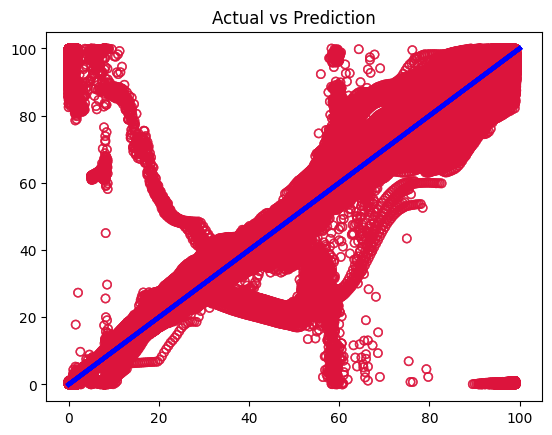

In [8]:
file_names = ['JL_I_0_new_.xlsx', 'JL_I_2_new_.xlsx','JL_I_3_new_.xlsx','JL_I_5_new_.xlsx','JL_I_4_new_.xlsx',
              'JS_I_1_new_.xlsx', 'JS_I_2_new_.xlsx','JS_I_3_new_.xlsx','JS_I_5_new_.xlsx','JS_I_4_new_.xlsx',
              'AK_I_0_new_.xlsx', 'AK_I_2_new_.xlsx','AK_I_3_new_.xlsx','AK_I_5_new_.xlsx','AK_I_4_new_.xlsx',
              'VN_I_0_new_.xlsx', 'VN_I_2_new_.xlsx','VN_I_3_new_.xlsx','VN_I_5_new_.xlsx','VN_I_4_new_.xlsx',
              'VP_I_0_new_.xlsx', 'VP_I_2_new_.xlsx','VP_I_3_new_.xlsx','VP_I_5_new_.xlsx','VP_I_4_new_.xlsx',
             'SOE_I_0_new_.xlsx', 'SOE_I_2_new_.xlsx','SOE_I_3_new_.xlsx','SOE_I_5_new_.xlsx', 'SOE_I_4_new_.xlsx', 'SD_I_3_new_.xlsx', 'SD_I_4_new_.xlsx','SD_I_5_new_.xlsx',
             'SD_I_1_new_.xlsx','SD_I_2_new_.xlsx','TH_I_0_new_.xlsx', 'TH_I_2_new_.xlsx', 'TH_I_3_new_.xlsx','TH_I_4_new_.xlsx', 'TH_I_5_new_.xlsx'
             ,'PK_I_0_new_.xlsx', 'PK_I_2_new_.xlsx', 'PK_I_3_new_.xlsx','PK_I_5_new_.xlsx',
              'SKS_0_I_new_.xlsx', 'SKS_2_I_new_.xlsx','SKS_3_I_new_.xlsx','SKS_4_I_new_.xlsx','SKS_5_I_new_.xlsx',
            'PH_I_0_new_.xlsx',  'PH_I_2_new_.xlsx',  'PH_I_3_new_.xlsx',  'PH_I_4_new_.xlsx',  'PH_I_5_new_.xlsx',
            'YC_I_0_new_.xlsx',  'YC_I_2_new_.xlsx',  'YC_I_3_new_.xlsx',  'YC_I_4_new_.xlsx',  'YC_I_5_new_.xlsx'
              ]
subject_dict = {'VN':[0.90,0.63],'AK':[0.80,0.57],'JS':[0.89,0.64],'JL':[0.79,0.63],'SKS':[0.83, 0.58],'VP':[0.93, 0.77],'SOE':[0.90, 0.83],
                'SD':[0.83, 0.70], 'TH':[0.66, 0.52], 'PK':[0.90, 0.88], 'PH':[0.95,0.80], 'YC':[0.82,0.79]}
subject_names = ['VP','AK', 'SD','PH', 'YC','JL','JS', 'PK', 'SOE', 'TH','SKS', 'VN']#,'VN','AK' 'SOE'
sub_comb_list=[]
test_sub_list=[]
acc_list=[]
rmse_list=[]
test_acc_list=[]
test_rmse_list=[]


#path="/home/vtp/Gait_Phase_Prediction/Subject_data/Final_files/"
#result_path = "/home/vtp/Gait_Phase_Prediction/Results/final/"

path = "/home/hikikomori/Gait_Phase_Prediction/Data/Final Data/"
result_path = "/home/hikikomori/Gait_Phase_Prediction/Results/final/"

result_pkl_file=result_path+'results_ver_single_leg_right.pkl'
pkl_file=path+"all_sub_vae_ver_single_leg_right.pkl"
# pkl_file=path+"good_sub_data.pkl"

for sub in subject_names:

  test_sub_list.append(sub)
  tmp=subject_names.copy()
  tmp.remove(sub)
  sub_comb_list.append(tmp)

df_dict={}

if os.path.exists(pkl_file):
    # File is already in pickle format, read to dict
    with open(pkl_file, 'rb') as file:
        df_dict = pickle.load(file)
    
else:
    # File is not in pickle format/ does not exist, convert and save it as a pickle file

    for file_name in file_names:
        subject = file_name.split('_')[0]
        if subject not in subject_names:
            continue
        leg_len = subject_dict[subject][0]
        weight = subject_dict[subject][1]
        print("Reading file :", file_name)
        tmp=pd.read_excel(path+ file_name, sheet_name='Sheet1')

        #### Add r_ph_hip_l and r
        encode_phase(tmp, 'r_ph_hip')
    
        perc_column = tmp['perc']
        st_sw_col_l = tmp['st_sw_phase_l']
        st_sw_col_r= tmp['st_sw_phase_r']
        lhip_col = tmp['lhip_ang']
        rhip_col = tmp['rhip_ang']
        lhip_df=tmp['l_ph_hip']
        rhip_df=tmp['r_ph_hip']
        r_hip_ph_x = tmp['r_ph_hip_x']
        r_hip_ph_y = tmp['r_ph_hip_y']

        
        st_l_l_col = tmp[['st_l_l']]
        st_l_r_col = tmp[['st_l_r']]

        tmp = tmp.drop(columns=['perc', 'st_sw_phase_l', 'st_sw_phase_r', 'lhip_ang', 'rhip_ang','l_ph_hip','r_ph_hip', 'st_l_l', 'st_l_r', 'r_ph_hip_x', 'r_ph_hip_y'])

        scaler = MinMaxScaler()
        tmp['l_ph_hip'] = lhip_df
        tmp['r_ph_hip'] = rhip_df
        tmp['st_sw_phase_l'] = st_sw_col_l
        tmp['st_sw_phase_r'] = st_sw_col_l
        tmp['r_ph_hip_x'] = r_hip_ph_x
        tmp['r_ph_hip_y'] = r_hip_ph_y
        tmp['st_l_l'] = scaler.fit_transform( st_l_l_col)
        tmp['st_l_r'] = scaler.fit_transform( st_l_r_col)

        column_names = tmp.columns


        tmp['l_ph_hip']=tmp['l_ph_hip']/300
        tmp['r_ph_hip']=tmp['r_ph_hip']/300
        #tmp['r_ph_hip_x'] = tmp['r_ph_hip_x'] / 300
        #tmp['r_ph_hip_y'] = tmp['r_ph_hip_y'] / 300
        # tmp['l_ph_fo']=tmp['l_ph_fo']/300
        # tmp['r_ph_fo']=tmp['r_ph_fo']/300
        tmp['lcop']= tmp['lcop']*1000
        tmp['rcop']=tmp['rcop']*1000
        tmp['st_sw_phase_l']=tmp['st_sw_phase_l']/200
        tmp['st_sw_phase_r']=tmp['st_sw_phase_r']/200

        normalized_df =tmp

        normalized_df['leg_len']=leg_len
        normalized_df['weight']=weight
        normalized_df['perc']= perc_column

        df_dict[subject] = normalized_df
    with open(pkl_file,'wb') as pickle_file:
        pickle.dump(df_dict, pickle_file)

#sub_cnt_file='sub_cnt.pkl'

with open(result_path+"all_results_vae2.txt","w") as file:  
    for sub_iter, sub_comb in enumerate(sub_comb_list):
    #for a_ in range(len(subject_names)):
        #sub_file=open(sub_cnt_file,'rb')
        #cnt=pickle.load(sub_file)
        #sub_file.close()
        #if cnt==len(subject_names):
        #    print("Done with all subjects !!")
        #    break
        #sub_comb=sub_comb_list[cnt]
        #sub_iter=cnt
        print("Subject combination :",sub_comb)
        sub_tag=test_sub_list[sub_iter]
        # all_data=get_data_frames_from_files(path, file_names, subject_dict, sub_comb)
        file_list=[]
        for sub in sub_comb:
          tmp_df=df_dict[sub]
          file_list.append(tmp_df)
        random.shuffle(file_list)
        
        all_data = pd.concat(file_list, axis=0, ignore_index=True)
        print("All Data Info: ")
        all_data.info()
        train_x, train_y, validation_x, validation_y = get_train_data_from_df(all_data, 0.25)
        print("Nan in train x at indices:",np.argwhere(np.isnan(train_x)))
        print("Nan in train y at indices:",np.argwhere(np.isnan(train_y)))

        print(train_x.shape)
        print(validation_x.shape)
        print("SSS")
        seq_len = train_x.shape[1]
        n_features = train_x.shape[2]
        encoder=[]
        decoder=[]
        mlp_model=[]
        encoder,decoder = train_vae(train_x)
        print("OKAY till here 1")

        samp_t=create_latent_space_train_mlp(encoder, train_x)
        mlp_model = train_mlp_model(samp_t, train_y)
        file.write("Training Result :")
        file.write("\n")
        acc, rmse=test_model_get_results(encoder,mlp_model, validation_x, validation_y, False, sub_tag, file)
        acc_list.append(acc)
        rmse_list.append(rmse)
        print("testing on :", test_sub_list[sub_iter])
        file.write("Testing  Result :")
        file.write(test_sub_list[sub_iter])
        file.write("\n")
        # all_data=get_data_frames_from_files(path, file_names, subject_dict, [test_sub_list[sub_iter]])
        all_data = df_dict[test_sub_list[sub_iter]]
        test_x, test_y, validation_x, validation_y = get_train_data_from_df(all_data, 0.25)
        acc, rmse=test_model_get_results(encoder,mlp_model, test_x, test_y, True, sub_tag, file)
        # tf.keras.backend.clear_session()

        test_acc_list.append(acc)
        test_rmse_list.append(rmse)
        # break
        # file.write(acc)
        file.write("\n")
        #cnt=cnt+1
        #sub_file=open(sub_cnt_file,'wb')
        #pickle.dump(cnt, sub_file)
        #sub_file.close()
        # if sub_iter>=5:
        # break
    file.close()


In [9]:
personInfo = pickle.load(open(result_pkl_file, "rb"))
print(personInfo)

{'VP': {'rmse': 2.7625054368488544, 'prec_list': [42.56934378301354, 71.82517259170086, 85.36962877429183, 92.41824926909564, 95.36643490651795]}, 'AK': {'rmse': 3.9975388071437292, 'prec_list': [27.753262604450285, 48.960191531311615, 65.712139705192, 76.31912496479204, 83.10252558445217]}, 'SD': {'rmse': 6.117258514274334, 'prec_list': [23.730006758278893, 42.9798378013066, 56.19227303446722, 65.86505969813021, 73.63708042351881]}, 'PH': {'rmse': 3.5664857915259187, 'prec_list': [36.01313108444646, 69.31401403667648, 85.94068372198325, 93.1650441476115, 95.7708852162101]}, 'YC': {'rmse': 16.873627855417357, 'prec_list': [6.161523024353203, 11.390139393610674, 16.1306069317134, 21.242609969083908, 27.040733308021913]}, 'JL': {'rmse': 3.6691621710943005, 'prec_list': [41.854584399357414, 65.02350211221516, 76.25691676087345, 83.75379306241447, 88.98375676801332]}, 'JS': {'rmse': 4.218574789718292, 'prec_list': [37.935402153261556, 62.82909617298471, 77.42920474079436, 85.79571157151905